# Solutions: Lossy Compression With a beta-Variational Autoencoder

- This notebook is part of the solutions to Problem Set 10, published on 28 June 2023 and discussed on 5 July 2023.
- You can download the full solutions (and the original problem set) from the [course website](https://robamler.github.io/teaching/compress23/).

In this problem, we implemented a toy beta-variational autoencoder ($\beta$-VAE), and we then used it to lossily compress images.

## Beta-Variational Autoencoder ($\beta$-VAE)

### System Setup

Let's install and import some libraries, and set some global configurations.

In [1]:
%pip install torch torchvision matplotlib tqdm


[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import time
import sys

In [3]:
USE_CUDA = False # change to True if you have a compatible GPU
RANDOM_SEED = 20230619
BATCH_SIZE = 100
EPOCHS = 10

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if USE_CUDA else "cpu")

### Data Set: MNIST

In contrast to our setup for lossless compression, there is no point in binarizing the pixels for lossy compression.

In [4]:
train_set = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_set = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

#### Visualize Some Training Data Points

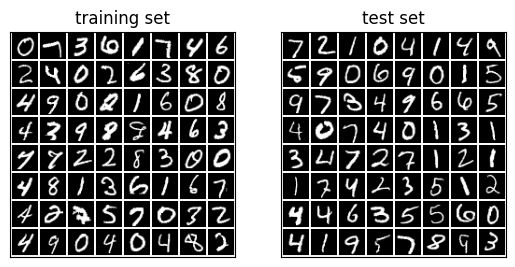

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

def plot_samples(ax, loader, title):
    dat, _ = next(loader.__iter__())
    ax.set_title(title)
    ax.imshow(1 - make_grid(1 - dat.data[:64].float(), padding=2).permute((1, 2, 0)))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

plot_samples(ax1, train_loader, "training set")
plot_samples(ax2, test_loader, "test set")


### Baselines

Our baseline for lossy compression is the lossless compression that we implemented on the last problem set.
Recall that we obtained about 0.23 bits per pixel there.
Our lossy compression method should be able to achieve a lower bit rate without completely corrupting the images to a point where we can't recognize anything anymore.

### Definition of Model Components

The classes `EntropyBottleneck`, `EncoderModel`, `DecoderModel`, below implement the components of the $\beta$-VAE.

#### Problem 10.2 (a): `EntropyBottleneck`

The class `EntropyBottleneck` implements the bit rate term $\mathcal R(\theta,\phi,\mathbf x)$ from Eq. 3 on the problem set.
Here, we assume a prior $P_\theta(\mathbf z)=\mathcal N(0, S_\theta)$ where $S_\theta$ is a diagonal covariance matrix with learned entries.
More precisely, we learn a separate variance for each channel (last tensor dimension of `z`), but we assume that the prior is identical at each horizontal and vertical position (this will allow us again to apply the trained model to images of arbitrary size).

In [6]:
class EntropyBottleneck(nn.Module):
    """The prior $P_\theta(Z)$."""

    def __init__(self, z_channels=3):
        super(EntropyBottleneck, self).__init__()
        self.prior_log_variance = torch.nn.Parameter(torch.ones((1, z_channels, 1, 1)))

    def forward(self, z):
        """Returns the term inside the expectation in Eq. 3 of the problem set, i.e.,
        $-\sum_i \log( \int_{z_i-0.5}^{z_i+0.5} p_i(z'_i) dz'_i )$ where p_i is a pdf
        of the i-th dimension of the prior. This allows us to estimate the rate term
        $KL( Q(Z|X=x) || P_\theta(Z) )$ for a box-shaped Q by sampling z from Q."""

        def antiderivative_of_normal(x, inverse_std):
            """Returns the antiderivative of a normal distribution with mean
            zero and standard deviation `1 / inverse_std`, evaluated at x."""
            return 0.5 * torch.erf((1 / np.sqrt(2)) * inverse_std * x)
        
        inverse_prior_std = torch.exp(-0.5 * self.prior_log_variance)
        
        # TODO: use the function `antiderivative_of_normal` defined above to evaluate
        # $\tilde p(z)$ as defined in Eq. 6 of the problem set (about 2 lines of code).
        #
        # PROPOSED SOLUTION:
        p_tilde = (antiderivative_of_normal(z + 0.5, inverse_prior_std)
                   - antiderivative_of_normal(z - 0.5, inverse_prior_std))

        return -p_tilde.log().sum()

    def prior_std(self):
        """Returns a tensor of prior standard deviations."""
        return torch.exp(0.5 * self.prior_log_variance)

    def entropy_per_latent_dim(self):
        """Returns $H_P(Z) / dim(Z)$ (mostly for debugging purpose)."""
        return 0.5 * torch.mean(np.log(2*np.pi) + 1 + self.prior_log_variance)

#### Problem 10.2 (b): `EncoderModel`

The `EncoderModel` is a neural network with weights $\phi$ that takes a batch of images $\mathbf x$ as input and outputs the parameters $\boldsymbol\mu_\phi(\boldsymbol x)$ of a box-shaped variational distribution that is centered at $\boldsymbol\mu_\phi(\boldsymbol x)$ and has width 1 in each coordinate direction.

In [7]:
class EncoderModel(nn.Module):
    """A box-shaped variational distribution $Q(Z|X)$."""

    def __init__(self, hidden_channels=4, z_channels=3):
        super(EncoderModel, self).__init__()
        self.z_shape = [z_channels, 4, 4]
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=hidden_channels,
            kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=hidden_channels, out_channels=z_channels,
            kernel_size=5, stride=2)
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)

    def forward(self, x):
        """Returns the parameters that define $Q(Z|X=x)$ for given $x$."""
        hidden = torch.relu(self.conv1(x))
        q_mean = self.conv2(hidden)
        return q_mean
    
    def reparameterize(self, q_mean):
        """Draws $z ~ Q(Z|X=x)$ using the reparameterization trick (see Problem 8.2)."""
        # TODO: implement this method (1 or 2 lines of code);
        # Hints:
        # - the method `torch.rand_like` draws uniform samples from the interval [0, 1).
        # - for the VAE on the last problem set (with a Gaussian variational distribution),
        #   we had the following implementation:
        #   q_std = torch.exp(0.5 * q_log_variance) # Using torch.exp ensures that std > 0.
        #   eps = torch.randn_like(q_std) # `randn` is standard normal distribution.
        #   return q_mean + q_std * eps
        #
        # PROPOSED SOLUTION:
        eps = torch.rand_like(q_mean) - 0.5 # uniform within [-0.5, 0.5] for each coordinate
        return q_mean + eps

#### Problem 10.2 (c): `DecoderModel`

The `DecoderModel` is a neural network with parameters $\theta$ that takes a batch of latent representations $\mathbf z$ as input and outputs a reconstructed image $\mathbf x'$.

In [8]:
class DecoderModel(nn.Module):
    """Maps z to a reconstructed image."""

    def __init__(self, z_channels=3, hidden_channels=4):
        super(DecoderModel, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(
            in_channels=z_channels, out_channels=hidden_channels,
            kernel_size=5, stride=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=hidden_channels, out_channels=1,
            kernel_size=5, stride=2, output_padding=1)
        nn.init.xavier_uniform_(self.deconv1.weight)
        nn.init.xavier_uniform_(self.deconv2.weight)

    def forward(self, z):
        """Returns a reconstructed image for given $z$."""
        hidden = torch.relu(self.deconv1(z))
        reconstruction = torch.clip(self.deconv2(hidden), 0, 1)
        return reconstruction

    def distortion(self, reconstruction, x):
        """Returns the 2-norm reconstruction error."""
        # TODO: return the distortion as defined below Eq. 1 on the problem
        # set, where $g(z)$ is given by the argument `reconstrution`.
        # (1 line of code)
        #
        # PROPOSED SOLUTION:
        return torch.sum((reconstruction - x)**2)


### Problem 10.2 (d): Tying the Components Together

In [9]:
def bit_rate_and_reconstruction(encoder_model, decoder_model, entropy_bottleneck, x):
    """Executes a round trip x --> z --> x';
    returns the estimated bit rate (to base 2), the distortion,
    the reconstructed images, and the total latent dimension."""
    q_mean = encoder_model(x)
    z = encoder_model.reparameterize(q_mean)
    bit_rate = entropy_bottleneck(z) / np.log(2)
    reconstructions = decoder_model(z)

    # TODO: in our VAE for lossless compression on Problem Set 9, we
    # had the following line:
    #
    # bit_rate_x_given_z = -decoder_model.log_likelihood(logits, x) / np.log(2)
    #
    # What should you replace this line with in order to train a VAE
    # for *lossy* data compression? Fill in 1 missing line of code.
    #
    # PROPOSED SOLUTION:
    distortion = decoder_model.distortion(reconstructions, x)
    # Note: calculating `bit_rate_x_given_z` does not make sense for our lossy
    # setup because we no longer encode the true `x` using the likelihood model.

    return bit_rate, distortion, reconstructions, z.numel()

### Training and Testing Functions

In [10]:
def train_one_epoch(epoch, beta, train_loader, encoder_model, decoder_model,
                    entropy_bottleneck, optimizer, batches_between_logging=100):
    # Set all parts of the model into training mode.
    encoder_model.train()
    decoder_model.train()
    entropy_bottleneck.train()

    total_bit_rate = 0
    total_distortion = 0
    total_num_pixels = 0
    for batch_idx, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        bit_rate, distortion, _, num_z = bit_rate_and_reconstruction(
            encoder_model, decoder_model, entropy_bottleneck, batch)
        loss = beta * bit_rate + distortion
        loss.backward()
        optimizer.step()

        total_bit_rate += bit_rate
        total_distortion += distortion
        total_num_pixels += batch.numel()
        
        if batch_idx % batches_between_logging == 0:
            bpp = bit_rate / batch.numel()
            mse = distortion / batch.numel() # (MSE = mean squared error)
            loss_pp = loss / batch.numel() # (MSE = mean squared error)
            entropy_pz = entropy_bottleneck.entropy_per_latent_dim()
            entropy_pp = entropy_pz * num_z / batch.numel()
            print(
                f'Training epoch {epoch}, batch {batch_idx: 3d} of {len(train_loader)}: ' +
                f'BPP = {bpp:.4f}; MSE = {mse:.4f}; loss per pixel = {loss_pp:.4f};'
            )
            print(f'  prior entropy (per pixel, per latent dim): {entropy_pp:.4f}, {entropy_pz:.4f}')
            sys.stdout.flush()

    bpp = total_bit_rate / total_num_pixels
    mse = total_distortion / total_num_pixels
    return bpp, mse

In [11]:
def test(test_loader, encoder_model, decoder_model, entropy_bottleneck):
    # Set all parts of the model into evaluation mode.
    encoder_model.eval()
    decoder_model.eval()
    entropy_bottleneck.eval()

    rendered_reconstructions = None
    total_bit_rate = 0
    total_distortion = 0
    total_num_pixels = 0

    with torch.no_grad():
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.to(device)
            bit_rate, distortion, reconstructions, _ = bit_rate_and_reconstruction(
                encoder_model, decoder_model, entropy_bottleneck, batch)
            total_bit_rate += bit_rate
            total_distortion += distortion
            total_num_pixels += batch.numel()

        # Prepare a tensor that can be plotted to show a few reconstructions.
        comparison = torch.cat([batch[:8], reconstructions[:8]])
        rendered_reconstructions = make_grid(comparison.cpu()).permute((1, 2, 0))

        bpp = total_bit_rate / total_num_pixels
        mse = total_distortion / total_num_pixels

    return bpp, mse, rendered_reconstructions

### Train the VAE

In [12]:
def training_loop(beta, train_loader, encoder_model, decoder_model, entropy_bottleneck, optimizer):
    # Create a placeholder figure that will be updated after each epoch below.
    figure, (samples_plot, reconstructions_plot) = plt.subplots(1, 2)
    samples_plot.set_title('samples')
    samples_plot.xaxis.set_visible(False)
    samples_plot.yaxis.set_visible(False)
    reconstructions_plot.set_title('test images and\ntheir reconstructions')
    reconstructions_plot.xaxis.set_visible(False)
    reconstructions_plot.yaxis.set_visible(False)
    hdisplay = display.display(figure, display_id=True)

    for epoch in range(1, EPOCHS + 1):
        start_time = time.time()
        train_bpp, train_mse = train_one_epoch(
            epoch, beta, train_loader, encoder_model, decoder_model, entropy_bottleneck,
            optimizer)
        test_bpp, test_mse, reconstructions = test(
            test_loader, encoder_model, decoder_model, entropy_bottleneck)
        end_time = time.time()
        train_loss = train_mse + beta * train_bpp
        test_loss = test_mse + beta * test_bpp
        print(
            f'Epoch {epoch} of {EPOCHS} ({end_time - start_time:.0f} sec): ' +
            f'training (BPP, MSE, loss): {train_bpp:.4f}, {train_mse:.4f}, {train_loss:.4f};  ' +
            f'test: {test_bpp:.4f}, {test_mse:.4f}, {test_loss:.4f}')
        sys.stdout.flush()

        # Plot some random samples $x ~ P(X)$ and reconstructions of test data.
        samples_plot.set_title(f'samples (epoch {epoch})')
        reconstructions_plot.set_title(
            f'test images and\ntheir reconstructions\n(epoch {epoch})')
        with torch.no_grad():
            samples_z = torch.randn([64] + encoder_model.z_shape).to(device)
            samples_x = decoder_model(samples_z).cpu()
            samples_plot.imshow(make_grid(samples_x).permute((1, 2, 0)))
        reconstructions_plot.imshow(reconstructions)
        hdisplay.update(figure)

    return train_bpp, train_mse, test_bpp, test_mse

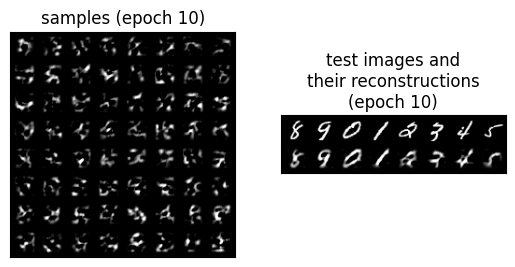

Training epoch 1, batch   0 of 600: BPP = 0.0865; MSE = 0.1131; loss per pixel = 0.1218;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0940; MSE = 0.0273; loss per pixel = 0.0367;
  prior entropy (per pixel, per latent dim): 0.0655, 1.6051
Training epoch 1, batch  200 of 600: BPP = 0.0981; MSE = 0.0253; loss per pixel = 0.0351;
  prior entropy (per pixel, per latent dim): 0.0643, 1.5745
Training epoch 1, batch  300 of 600: BPP = 0.0947; MSE = 0.0241; loss per pixel = 0.0336;
  prior entropy (per pixel, per latent dim): 0.0645, 1.5802
Training epoch 1, batch  400 of 600: BPP = 0.0971; MSE = 0.0234; loss per pixel = 0.0331;
  prior entropy (per pixel, per latent dim): 0.0645, 1.5799
Training epoch 1, batch  500 of 600: BPP = 0.0958; MSE = 0.0227; loss per pixel = 0.0323;
  prior entropy (per pixel, per latent dim): 0.0650, 1.5922
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.0943, 0.0269, 0.0363;  test: 0.0959, 0.0221, 0.03

(tensor(0.0980, grad_fn=<DivBackward0>),
 tensor(0.0212, grad_fn=<DivBackward0>),
 tensor(0.0987),
 tensor(0.0207))

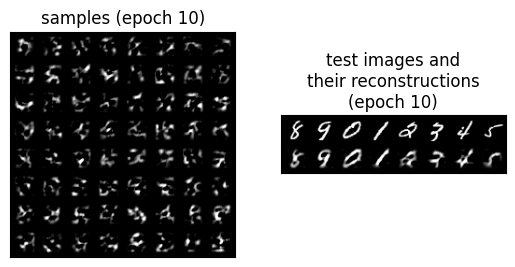

In [13]:
encoder_model = EncoderModel(z_channels=2).to(device)
decoder_model = DecoderModel(z_channels=2).to(device)
entropy_bottleneck = EntropyBottleneck(z_channels=2).to(device)

if USE_CUDA > 1:
    encoder_model = nn.DataParallel(encoder_model)
    decoder_model = nn.DataParallel(decoder_model)
    entropy_bottleneck = nn.DataParallel(entropy_bottleneck)

optimizer = optim.Adam(
    list(encoder_model.parameters())
    + list(decoder_model.parameters())
    + list(entropy_bottleneck.parameters()),
    lr=0.01)

training_loop(0.1, train_loader, encoder_model, decoder_model, entropy_bottleneck, optimizer)

### Problem 10.2 (e): Rate/Distortion Curves

**TODO:** implement a loop that trains $\beta$-VAEs for various values of $\beta$, and record the resulting bit rates and distortions after training.
Then plot the distortion as a function of the bit rate.
Come up with reasonable values for $\beta$ yourself.
Repeat the same for various dimensionalities of the latent space (argument `z_channels` in the three model constructors) and plot a rate/distortion curve for each tested value of `z_channels` in the same plot.

One typically finds that, for some dimensionalities of the latent space, the model performs better in the regime of low bit rates whereas for other dimensionalities, the model performs better in the regime of high bit rates.
For which values of `z_channel` do you expect the model to perform better in the high-bit-rate regime, and for which values do you expect it to perform better in the low-bit-rate regime?

#

#### Proposed Solution

  0%|          | 0/3 [00:00<?, ?it/s]

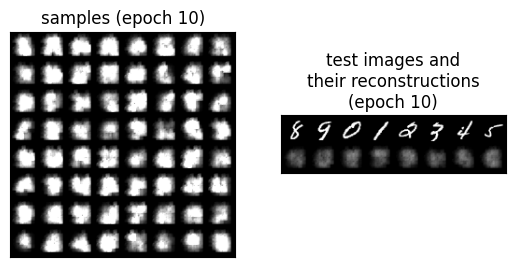

Training epoch 1, batch   0 of 600: BPP = 0.0431; MSE = 0.1127; loss per pixel = 0.5433;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0306; MSE = 0.0636; loss per pixel = 0.3700;
  prior entropy (per pixel, per latent dim): 0.0292, 1.4292
Training epoch 1, batch  200 of 600: BPP = 0.0199; MSE = 0.0667; loss per pixel = 0.2660;
  prior entropy (per pixel, per latent dim): 0.0200, 0.9800
Training epoch 1, batch  300 of 600: BPP = 0.0132; MSE = 0.0724; loss per pixel = 0.2044;
  prior entropy (per pixel, per latent dim): 0.0122, 0.5963
Training epoch 1, batch  400 of 600: BPP = 0.0092; MSE = 0.0746; loss per pixel = 0.1665;
  prior entropy (per pixel, per latent dim): 0.0060, 0.2947
Training epoch 1, batch  500 of 600: BPP = 0.0074; MSE = 0.0765; loss per pixel = 0.1508;
  prior entropy (per pixel, per latent dim): 0.0011, 0.0540
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.0173, 0.0715, 0.2445;  test: 0.0059, 0.0755, 0.13

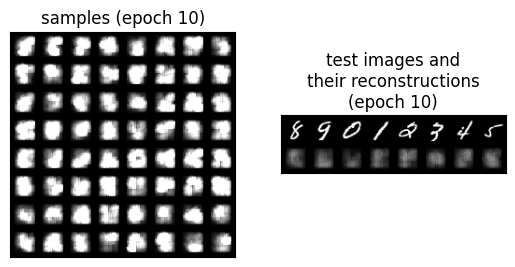

Training epoch 1, batch   0 of 600: BPP = 0.0428; MSE = 0.1195; loss per pixel = 0.2480;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0322; MSE = 0.0490; loss per pixel = 0.1456;
  prior entropy (per pixel, per latent dim): 0.0293, 1.4367
Training epoch 1, batch  200 of 600: BPP = 0.0237; MSE = 0.0538; loss per pixel = 0.1249;
  prior entropy (per pixel, per latent dim): 0.0208, 1.0198
Training epoch 1, batch  300 of 600: BPP = 0.0173; MSE = 0.0603; loss per pixel = 0.1121;
  prior entropy (per pixel, per latent dim): 0.0137, 0.6706
Training epoch 1, batch  400 of 600: BPP = 0.0131; MSE = 0.0632; loss per pixel = 0.1024;
  prior entropy (per pixel, per latent dim): 0.0080, 0.3903
Training epoch 1, batch  500 of 600: BPP = 0.0098; MSE = 0.0671; loss per pixel = 0.0965;
  prior entropy (per pixel, per latent dim): 0.0033, 0.1597
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0201, 0.0614, 0.1218;  test: 0.0083, 0.0695, 0.09

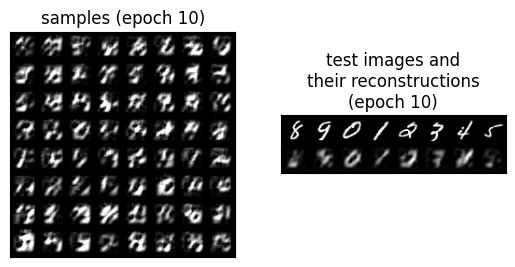

Training epoch 1, batch   0 of 600: BPP = 0.0428; MSE = 0.1151; loss per pixel = 0.1579;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0363; MSE = 0.0448; loss per pixel = 0.0811;
  prior entropy (per pixel, per latent dim): 0.0300, 1.4682
Training epoch 1, batch  200 of 600: BPP = 0.0301; MSE = 0.0411; loss per pixel = 0.0712;
  prior entropy (per pixel, per latent dim): 0.0228, 1.1168
Training epoch 1, batch  300 of 600: BPP = 0.0258; MSE = 0.0465; loss per pixel = 0.0723;
  prior entropy (per pixel, per latent dim): 0.0176, 0.8616
Training epoch 1, batch  400 of 600: BPP = 0.0236; MSE = 0.0496; loss per pixel = 0.0732;
  prior entropy (per pixel, per latent dim): 0.0142, 0.6965
Training epoch 1, batch  500 of 600: BPP = 0.0218; MSE = 0.0504; loss per pixel = 0.0722;
  prior entropy (per pixel, per latent dim): 0.0120, 0.5880
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0280, 0.0498, 0.0778;  test: 0.0203, 0.0515, 0.07

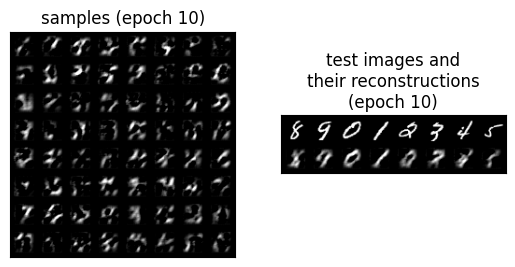

Training epoch 1, batch   0 of 600: BPP = 0.0454; MSE = 0.1050; loss per pixel = 0.1186;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0438; MSE = 0.0399; loss per pixel = 0.0531;
  prior entropy (per pixel, per latent dim): 0.0317, 1.5546
Training epoch 1, batch  200 of 600: BPP = 0.0419; MSE = 0.0403; loss per pixel = 0.0529;
  prior entropy (per pixel, per latent dim): 0.0286, 1.4017
Training epoch 1, batch  300 of 600: BPP = 0.0405; MSE = 0.0409; loss per pixel = 0.0531;
  prior entropy (per pixel, per latent dim): 0.0274, 1.3417
Training epoch 1, batch  400 of 600: BPP = 0.0400; MSE = 0.0406; loss per pixel = 0.0526;
  prior entropy (per pixel, per latent dim): 0.0270, 1.3245
Training epoch 1, batch  500 of 600: BPP = 0.0396; MSE = 0.0416; loss per pixel = 0.0535;
  prior entropy (per pixel, per latent dim): 0.0268, 1.3140
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0413, 0.0432, 0.0556;  test: 0.0413, 0.0401, 0.05

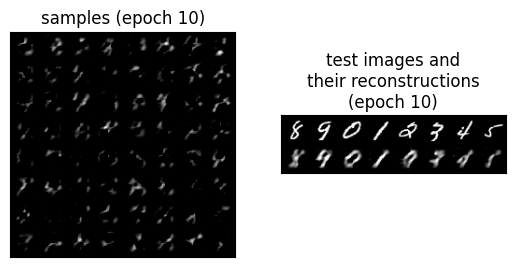

Training epoch 1, batch   0 of 600: BPP = 0.0428; MSE = 0.1064; loss per pixel = 0.1107;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0546; MSE = 0.0396; loss per pixel = 0.0450;
  prior entropy (per pixel, per latent dim): 0.0357, 1.7482
Training epoch 1, batch  200 of 600: BPP = 0.0567; MSE = 0.0355; loss per pixel = 0.0412;
  prior entropy (per pixel, per latent dim): 0.0390, 1.9109
Training epoch 1, batch  300 of 600: BPP = 0.0591; MSE = 0.0364; loss per pixel = 0.0424;
  prior entropy (per pixel, per latent dim): 0.0409, 2.0055
Training epoch 1, batch  400 of 600: BPP = 0.0613; MSE = 0.0334; loss per pixel = 0.0396;
  prior entropy (per pixel, per latent dim): 0.0416, 2.0369
Training epoch 1, batch  500 of 600: BPP = 0.0595; MSE = 0.0344; loss per pixel = 0.0403;
  prior entropy (per pixel, per latent dim): 0.0417, 2.0430
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0576, 0.0395, 0.0452;  test: 0.0621, 0.0348, 0.04

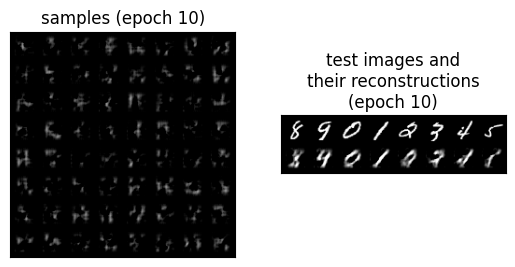

Training epoch 1, batch   0 of 600: BPP = 0.0432; MSE = 0.1058; loss per pixel = 0.1071;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0641; MSE = 0.0372; loss per pixel = 0.0391;
  prior entropy (per pixel, per latent dim): 0.0376, 1.8403
Training epoch 1, batch  200 of 600: BPP = 0.0697; MSE = 0.0373; loss per pixel = 0.0394;
  prior entropy (per pixel, per latent dim): 0.0457, 2.2383
Training epoch 1, batch  300 of 600: BPP = 0.0729; MSE = 0.0366; loss per pixel = 0.0387;
  prior entropy (per pixel, per latent dim): 0.0492, 2.4089
Training epoch 1, batch  400 of 600: BPP = 0.0719; MSE = 0.0356; loss per pixel = 0.0378;
  prior entropy (per pixel, per latent dim): 0.0501, 2.4529
Training epoch 1, batch  500 of 600: BPP = 0.0727; MSE = 0.0346; loss per pixel = 0.0368;
  prior entropy (per pixel, per latent dim): 0.0508, 2.4905
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0682, 0.0386, 0.0406;  test: 0.0742, 0.0340, 0.03

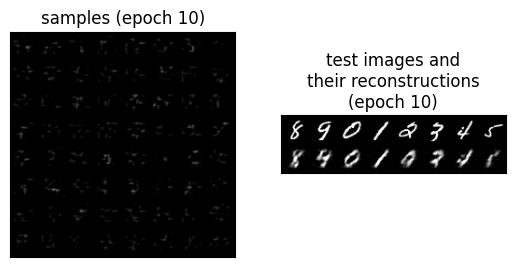

Training epoch 1, batch   0 of 600: BPP = 0.0441; MSE = 0.1151; loss per pixel = 0.1155;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0737; MSE = 0.0371; loss per pixel = 0.0379;
  prior entropy (per pixel, per latent dim): 0.0397, 1.9467
Training epoch 1, batch  200 of 600: BPP = 0.0832; MSE = 0.0361; loss per pixel = 0.0370;
  prior entropy (per pixel, per latent dim): 0.0514, 2.5193
Training epoch 1, batch  300 of 600: BPP = 0.0836; MSE = 0.0357; loss per pixel = 0.0365;
  prior entropy (per pixel, per latent dim): 0.0572, 2.8026
Training epoch 1, batch  400 of 600: BPP = 0.0845; MSE = 0.0364; loss per pixel = 0.0372;
  prior entropy (per pixel, per latent dim): 0.0589, 2.8870
Training epoch 1, batch  500 of 600: BPP = 0.0875; MSE = 0.0360; loss per pixel = 0.0369;
  prior entropy (per pixel, per latent dim): 0.0602, 2.9521
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0798, 0.0385, 0.0393;  test: 0.0884, 0.0344, 0.03

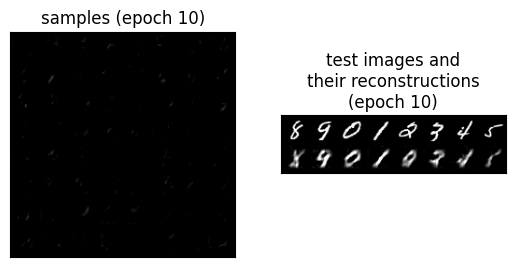

Training epoch 1, batch   0 of 600: BPP = 0.0429; MSE = 0.1089; loss per pixel = 0.1090;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0825; MSE = 0.0419; loss per pixel = 0.0421;
  prior entropy (per pixel, per latent dim): 0.0422, 2.0660
Training epoch 1, batch  200 of 600: BPP = 0.0888; MSE = 0.0354; loss per pixel = 0.0357;
  prior entropy (per pixel, per latent dim): 0.0538, 2.6365
Training epoch 1, batch  300 of 600: BPP = 0.0903; MSE = 0.0357; loss per pixel = 0.0360;
  prior entropy (per pixel, per latent dim): 0.0595, 2.9132
Training epoch 1, batch  400 of 600: BPP = 0.0914; MSE = 0.0362; loss per pixel = 0.0364;
  prior entropy (per pixel, per latent dim): 0.0620, 3.0397
Training epoch 1, batch  500 of 600: BPP = 0.0929; MSE = 0.0383; loss per pixel = 0.0386;
  prior entropy (per pixel, per latent dim): 0.0635, 3.1110
Epoch 1 of 10 (18 sec): training (BPP, MSE, loss): 0.0852, 0.0388, 0.0390;  test: 0.0927, 0.0347, 0.0

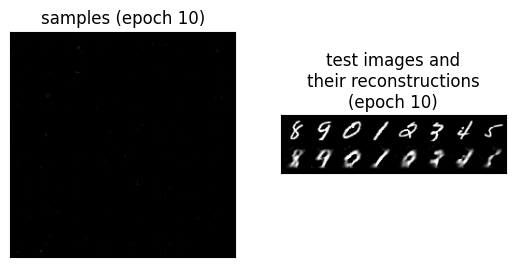

Training epoch 1, batch   0 of 600: BPP = 0.0427; MSE = 0.0962; loss per pixel = 0.0962;
  prior entropy (per pixel, per latent dim): 0.0391, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0839; MSE = 0.0391; loss per pixel = 0.0392;
  prior entropy (per pixel, per latent dim): 0.0430, 2.1074
Training epoch 1, batch  200 of 600: BPP = 0.0927; MSE = 0.0366; loss per pixel = 0.0367;
  prior entropy (per pixel, per latent dim): 0.0538, 2.6366
Training epoch 1, batch  300 of 600: BPP = 0.0933; MSE = 0.0364; loss per pixel = 0.0365;
  prior entropy (per pixel, per latent dim): 0.0606, 2.9671
Training epoch 1, batch  400 of 600: BPP = 0.0958; MSE = 0.0344; loss per pixel = 0.0345;
  prior entropy (per pixel, per latent dim): 0.0644, 3.1548
Training epoch 1, batch  500 of 600: BPP = 0.0981; MSE = 0.0330; loss per pixel = 0.0331;
  prior entropy (per pixel, per latent dim): 0.0664, 3.2543
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.0890, 0.0373, 0.0374;  test: 0.0998, 0.0334, 0.03

 33%|███▎      | 1/3 [13:09<26:19, 789.88s/it]

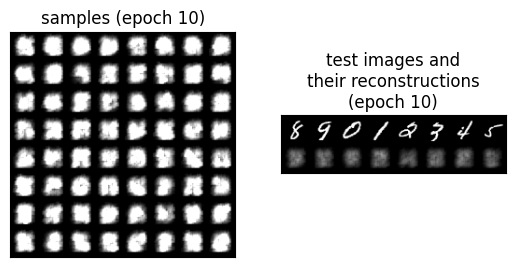

Training epoch 1, batch   0 of 600: BPP = 0.0860; MSE = 0.1128; loss per pixel = 0.9725;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0604; MSE = 0.0588; loss per pixel = 0.6624;
  prior entropy (per pixel, per latent dim): 0.0582, 1.4256
Training epoch 1, batch  200 of 600: BPP = 0.0393; MSE = 0.0660; loss per pixel = 0.4589;
  prior entropy (per pixel, per latent dim): 0.0398, 0.9758
Training epoch 1, batch  300 of 600: BPP = 0.0256; MSE = 0.0698; loss per pixel = 0.3260;
  prior entropy (per pixel, per latent dim): 0.0244, 0.5967
Training epoch 1, batch  400 of 600: BPP = 0.0186; MSE = 0.0760; loss per pixel = 0.2624;
  prior entropy (per pixel, per latent dim): 0.0123, 0.3008
Training epoch 1, batch  500 of 600: BPP = 0.0145; MSE = 0.0752; loss per pixel = 0.2203;
  prior entropy (per pixel, per latent dim): 0.0026, 0.0632
Epoch 1 of 10 (11 sec): training (BPP, MSE, loss): 0.0343, 0.0696, 0.4130;  test: 0.0118, 0.0746, 0.1

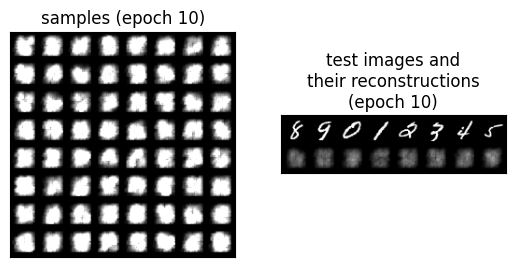

Training epoch 1, batch   0 of 600: BPP = 0.0870; MSE = 0.1113; loss per pixel = 0.3722;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0638; MSE = 0.0426; loss per pixel = 0.2341;
  prior entropy (per pixel, per latent dim): 0.0585, 1.4337
Training epoch 1, batch  200 of 600: BPP = 0.0441; MSE = 0.0472; loss per pixel = 0.1796;
  prior entropy (per pixel, per latent dim): 0.0410, 1.0048
Training epoch 1, batch  300 of 600: BPP = 0.0312; MSE = 0.0569; loss per pixel = 0.1507;
  prior entropy (per pixel, per latent dim): 0.0263, 0.6444
Training epoch 1, batch  400 of 600: BPP = 0.0226; MSE = 0.0602; loss per pixel = 0.1281;
  prior entropy (per pixel, per latent dim): 0.0145, 0.3555
Training epoch 1, batch  500 of 600: BPP = 0.0176; MSE = 0.0643; loss per pixel = 0.1172;
  prior entropy (per pixel, per latent dim): 0.0049, 0.1191
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0380, 0.0565, 0.1706;  test: 0.0144, 0.0674, 0.11

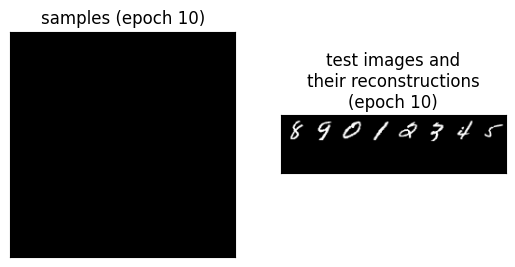

Training epoch 1, batch   0 of 600: BPP = 0.0857; MSE = 0.0987; loss per pixel = 0.1844;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0680; MSE = 0.0378; loss per pixel = 0.1059;
  prior entropy (per pixel, per latent dim): 0.0593, 1.4517
Training epoch 1, batch  200 of 600: BPP = 0.0524; MSE = 0.0381; loss per pixel = 0.0906;
  prior entropy (per pixel, per latent dim): 0.0434, 1.0629
Training epoch 1, batch  300 of 600: BPP = 0.0442; MSE = 0.0417; loss per pixel = 0.0859;
  prior entropy (per pixel, per latent dim): 0.0310, 0.7600
Training epoch 1, batch  400 of 600: BPP = 0.0372; MSE = 0.0427; loss per pixel = 0.0799;
  prior entropy (per pixel, per latent dim): 0.0221, 0.5413
Training epoch 1, batch  500 of 600: BPP = 0.0338; MSE = 0.0448; loss per pixel = 0.0786;
  prior entropy (per pixel, per latent dim): 0.0159, 0.3888
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0486, 0.0419, 0.0905;  test: 0.0312, 0.0454, 0.07

/home/robamler/compression-course/venv/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


Training epoch 9, batch   0 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Training epoch 9, batch  100 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Training epoch 9, batch  200 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Training epoch 9, batch  300 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Training epoch 9, batch  400 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Training epoch 9, batch  500 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Epoch 9 of 10 (8 sec): training (BPP, MSE, loss): nan, nan, nan;  test: nan, nan, nan
Training epoch 10, batch   0 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pix

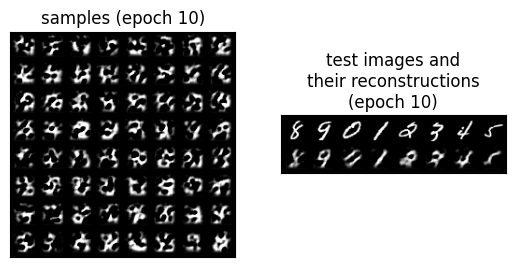

Training epoch 1, batch   0 of 600: BPP = 0.0856; MSE = 0.1017; loss per pixel = 0.1274;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0787; MSE = 0.0264; loss per pixel = 0.0500;
  prior entropy (per pixel, per latent dim): 0.0613, 1.5017
Training epoch 1, batch  200 of 600: BPP = 0.0694; MSE = 0.0285; loss per pixel = 0.0493;
  prior entropy (per pixel, per latent dim): 0.0493, 1.2091
Training epoch 1, batch  300 of 600: BPP = 0.0644; MSE = 0.0265; loss per pixel = 0.0459;
  prior entropy (per pixel, per latent dim): 0.0427, 1.0449
Training epoch 1, batch  400 of 600: BPP = 0.0603; MSE = 0.0300; loss per pixel = 0.0481;
  prior entropy (per pixel, per latent dim): 0.0400, 0.9804
Training epoch 1, batch  500 of 600: BPP = 0.0627; MSE = 0.0285; loss per pixel = 0.0473;
  prior entropy (per pixel, per latent dim): 0.0390, 0.9547
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0687, 0.0302, 0.0508;  test: 0.0634, 0.0271, 0.04

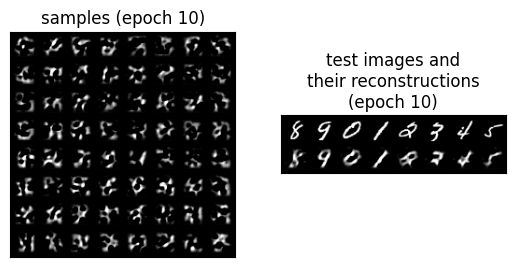

Training epoch 1, batch   0 of 600: BPP = 0.0857; MSE = 0.1061; loss per pixel = 0.1146;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.0952; MSE = 0.0243; loss per pixel = 0.0338;
  prior entropy (per pixel, per latent dim): 0.0665, 1.6283
Training epoch 1, batch  200 of 600: BPP = 0.0938; MSE = 0.0231; loss per pixel = 0.0325;
  prior entropy (per pixel, per latent dim): 0.0649, 1.5899
Training epoch 1, batch  300 of 600: BPP = 0.0944; MSE = 0.0224; loss per pixel = 0.0318;
  prior entropy (per pixel, per latent dim): 0.0650, 1.5935
Training epoch 1, batch  400 of 600: BPP = 0.0931; MSE = 0.0224; loss per pixel = 0.0317;
  prior entropy (per pixel, per latent dim): 0.0649, 1.5895
Training epoch 1, batch  500 of 600: BPP = 0.0974; MSE = 0.0242; loss per pixel = 0.0340;
  prior entropy (per pixel, per latent dim): 0.0645, 1.5804
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.0950, 0.0254, 0.0349;  test: 0.0953, 0.0214, 0.03

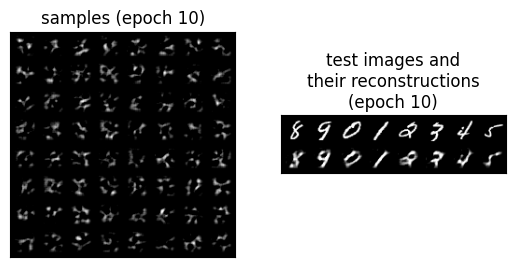

Training epoch 1, batch   0 of 600: BPP = 0.0855; MSE = 0.1005; loss per pixel = 0.1030;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1173; MSE = 0.0261; loss per pixel = 0.0296;
  prior entropy (per pixel, per latent dim): 0.0746, 1.8285
Training epoch 1, batch  200 of 600: BPP = 0.1244; MSE = 0.0218; loss per pixel = 0.0255;
  prior entropy (per pixel, per latent dim): 0.0838, 2.0524
Training epoch 1, batch  300 of 600: BPP = 0.1287; MSE = 0.0194; loss per pixel = 0.0233;
  prior entropy (per pixel, per latent dim): 0.0887, 2.1731
Training epoch 1, batch  400 of 600: BPP = 0.1303; MSE = 0.0196; loss per pixel = 0.0235;
  prior entropy (per pixel, per latent dim): 0.0896, 2.1947
Training epoch 1, batch  500 of 600: BPP = 0.1313; MSE = 0.0187; loss per pixel = 0.0227;
  prior entropy (per pixel, per latent dim): 0.0904, 2.2154
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.1238, 0.0244, 0.0281;  test: 0.1321, 0.0192, 0.02

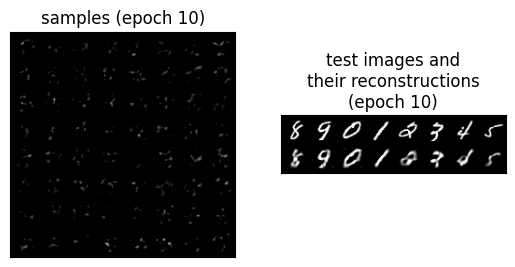

Training epoch 1, batch   0 of 600: BPP = 0.0857; MSE = 0.0999; loss per pixel = 0.1007;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1336; MSE = 0.0232; loss per pixel = 0.0245;
  prior entropy (per pixel, per latent dim): 0.0798, 1.9563
Training epoch 1, batch  200 of 600: BPP = 0.1452; MSE = 0.0205; loss per pixel = 0.0219;
  prior entropy (per pixel, per latent dim): 0.0963, 2.3588
Training epoch 1, batch  300 of 600: BPP = 0.1508; MSE = 0.0198; loss per pixel = 0.0213;
  prior entropy (per pixel, per latent dim): 0.1037, 2.5409
Training epoch 1, batch  400 of 600: BPP = 0.1581; MSE = 0.0194; loss per pixel = 0.0210;
  prior entropy (per pixel, per latent dim): 0.1075, 2.6328
Training epoch 1, batch  500 of 600: BPP = 0.1602; MSE = 0.0177; loss per pixel = 0.0193;
  prior entropy (per pixel, per latent dim): 0.1102, 2.7009
Epoch 1 of 10 (8 sec): training (BPP, MSE, loss): 0.1463, 0.0236, 0.0251;  test: 0.1623, 0.0186, 0.02

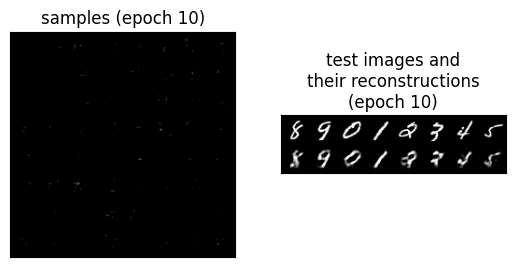

Training epoch 1, batch   0 of 600: BPP = 0.0865; MSE = 0.1172; loss per pixel = 0.1175;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1393; MSE = 0.0257; loss per pixel = 0.0261;
  prior entropy (per pixel, per latent dim): 0.0797, 1.9535
Training epoch 1, batch  200 of 600: BPP = 0.1582; MSE = 0.0213; loss per pixel = 0.0217;
  prior entropy (per pixel, per latent dim): 0.0991, 2.4281
Training epoch 1, batch  300 of 600: BPP = 0.1716; MSE = 0.0204; loss per pixel = 0.0209;
  prior entropy (per pixel, per latent dim): 0.1129, 2.7655
Training epoch 1, batch  400 of 600: BPP = 0.1772; MSE = 0.0207; loss per pixel = 0.0212;
  prior entropy (per pixel, per latent dim): 0.1200, 2.9408
Training epoch 1, batch  500 of 600: BPP = 0.1799; MSE = 0.0183; loss per pixel = 0.0189;
  prior entropy (per pixel, per latent dim): 0.1245, 3.0492
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.1607, 0.0236, 0.0241;  test: 0.1850, 0.0183, 0.01

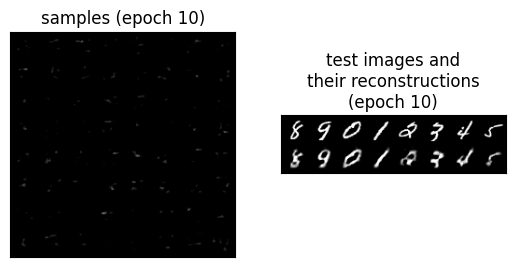

Training epoch 1, batch   0 of 600: BPP = 0.0857; MSE = 0.1153; loss per pixel = 0.1154;
  prior entropy (per pixel, per latent dim): 0.0781, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1438; MSE = 0.0276; loss per pixel = 0.0278;
  prior entropy (per pixel, per latent dim): 0.0796, 1.9510
Training epoch 1, batch  200 of 600: BPP = 0.1629; MSE = 0.0213; loss per pixel = 0.0215;
  prior entropy (per pixel, per latent dim): 0.1018, 2.4933
Training epoch 1, batch  300 of 600: BPP = 0.1747; MSE = 0.0203; loss per pixel = 0.0205;
  prior entropy (per pixel, per latent dim): 0.1157, 2.8335
Training epoch 1, batch  400 of 600: BPP = 0.1821; MSE = 0.0183; loss per pixel = 0.0185;
  prior entropy (per pixel, per latent dim): 0.1232, 3.0173
Training epoch 1, batch  500 of 600: BPP = 0.1839; MSE = 0.0213; loss per pixel = 0.0215;
  prior entropy (per pixel, per latent dim): 0.1262, 3.0930
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.1634, 0.0242, 0.0244;  test: 0.1864, 0.0188, 0.01

 67%|██████▋   | 2/3 [26:27<13:14, 794.22s/it]

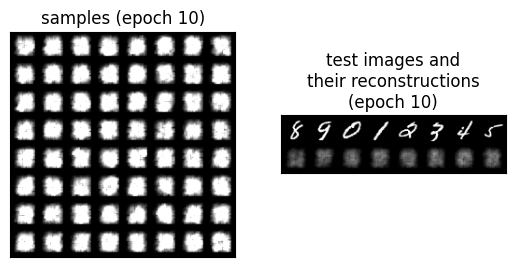

Training epoch 1, batch   0 of 600: BPP = 0.1712; MSE = 0.1160; loss per pixel = 1.8275;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1195; MSE = 0.0569; loss per pixel = 1.2522;
  prior entropy (per pixel, per latent dim): 0.1162, 1.4238
Training epoch 1, batch  200 of 600: BPP = 0.0784; MSE = 0.0635; loss per pixel = 0.8473;
  prior entropy (per pixel, per latent dim): 0.0795, 0.9744
Training epoch 1, batch  300 of 600: BPP = 0.0514; MSE = 0.0756; loss per pixel = 0.5901;
  prior entropy (per pixel, per latent dim): 0.0488, 0.5976
Training epoch 1, batch  400 of 600: BPP = 0.0369; MSE = 0.0703; loss per pixel = 0.4395;
  prior entropy (per pixel, per latent dim): 0.0248, 0.3044
Training epoch 1, batch  500 of 600: BPP = 0.0291; MSE = 0.0723; loss per pixel = 0.3637;
  prior entropy (per pixel, per latent dim): 0.0057, 0.0692
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.0683, 0.0700, 0.7528;  test: 0.0239, 0.0736, 0.31

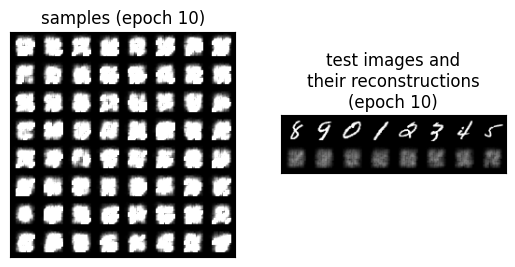

Training epoch 1, batch   0 of 600: BPP = 0.1723; MSE = 0.0997; loss per pixel = 0.6167;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1230; MSE = 0.0381; loss per pixel = 0.4072;
  prior entropy (per pixel, per latent dim): 0.1166, 1.4289
Training epoch 1, batch  200 of 600: BPP = 0.0832; MSE = 0.0439; loss per pixel = 0.2936;
  prior entropy (per pixel, per latent dim): 0.0807, 0.9888
Training epoch 1, batch  300 of 600: BPP = 0.0566; MSE = 0.0552; loss per pixel = 0.2248;
  prior entropy (per pixel, per latent dim): 0.0505, 0.6192
Training epoch 1, batch  400 of 600: BPP = 0.0408; MSE = 0.0632; loss per pixel = 0.1857;
  prior entropy (per pixel, per latent dim): 0.0267, 0.3266
Training epoch 1, batch  500 of 600: BPP = 0.0318; MSE = 0.0680; loss per pixel = 0.1634;
  prior entropy (per pixel, per latent dim): 0.0073, 0.0896
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.0722, 0.0538, 0.2705;  test: 0.0262, 0.0667, 0.14

/tmp/ipykernel_300123/866467548.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, (samples_plot, reconstructions_plot) = plt.subplots(1, 2)


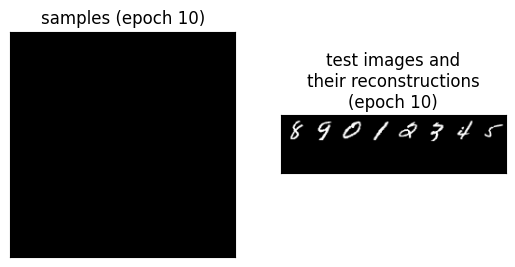

Training epoch 1, batch   0 of 600: BPP = 0.1731; MSE = 0.1019; loss per pixel = 0.2750;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1298; MSE = 0.0260; loss per pixel = 0.1558;
  prior entropy (per pixel, per latent dim): 0.1174, 1.4383
Training epoch 1, batch  200 of 600: BPP = 0.0933; MSE = 0.0304; loss per pixel = 0.1237;
  prior entropy (per pixel, per latent dim): 0.0832, 1.0192
Training epoch 1, batch  300 of 600: BPP = 0.0705; MSE = 0.0333; loss per pixel = 0.1039;
  prior entropy (per pixel, per latent dim): 0.0556, 0.6809
Training epoch 1, batch  400 of 600: BPP = 0.0572; MSE = 0.0406; loss per pixel = 0.0978;
  prior entropy (per pixel, per latent dim): 0.0347, 0.4254
Training epoch 1, batch  500 of 600: BPP = 0.0483; MSE = 0.0432; loss per pixel = 0.0914;
  prior entropy (per pixel, per latent dim): 0.0189, 0.2314
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.0845, 0.0371, 0.1216;  test: 0.0431, 0.0459, 0.08

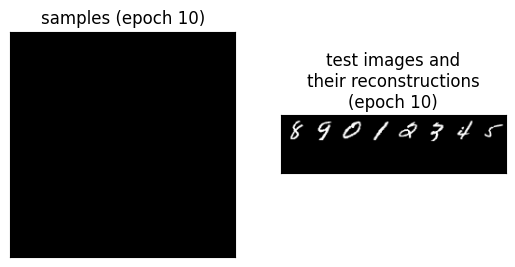

Training epoch 1, batch   0 of 600: BPP = 0.1740; MSE = 0.1065; loss per pixel = 0.1587;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1404; MSE = 0.0202; loss per pixel = 0.0624;
  prior entropy (per pixel, per latent dim): 0.1188, 1.4551
Training epoch 1, batch  200 of 600: BPP = 0.1164; MSE = 0.0210; loss per pixel = 0.0559;
  prior entropy (per pixel, per latent dim): 0.0886, 1.0853
Training epoch 1, batch  300 of 600: BPP = 0.0964; MSE = 0.0234; loss per pixel = 0.0523;
  prior entropy (per pixel, per latent dim): 0.0669, 0.8195
Training epoch 1, batch  400 of 600: BPP = 0.0870; MSE = 0.0265; loss per pixel = 0.0526;
  prior entropy (per pixel, per latent dim): 0.0534, 0.6543
Training epoch 1, batch  500 of 600: BPP = 0.0860; MSE = 0.0257; loss per pixel = 0.0515;
  prior entropy (per pixel, per latent dim): 0.0458, 0.5610
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.1085, 0.0260, 0.0585;  test: 0.0834, 0.0258, 0.05

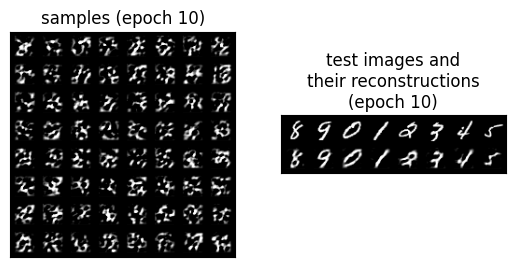

Training epoch 1, batch   0 of 600: BPP = 0.1714; MSE = 0.1002; loss per pixel = 0.1174;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1612; MSE = 0.0197; loss per pixel = 0.0358;
  prior entropy (per pixel, per latent dim): 0.1231, 1.5079
Training epoch 1, batch  200 of 600: BPP = 0.1432; MSE = 0.0186; loss per pixel = 0.0330;
  prior entropy (per pixel, per latent dim): 0.1029, 1.2600
Training epoch 1, batch  300 of 600: BPP = 0.1356; MSE = 0.0177; loss per pixel = 0.0312;
  prior entropy (per pixel, per latent dim): 0.0919, 1.1254
Training epoch 1, batch  400 of 600: BPP = 0.1309; MSE = 0.0174; loss per pixel = 0.0305;
  prior entropy (per pixel, per latent dim): 0.0873, 1.0691
Training epoch 1, batch  500 of 600: BPP = 0.1321; MSE = 0.0175; loss per pixel = 0.0307;
  prior entropy (per pixel, per latent dim): 0.0859, 1.0524
Epoch 1 of 10 (10 sec): training (BPP, MSE, loss): 0.1438, 0.0205, 0.0349;  test: 0.1337, 0.0167, 0.0

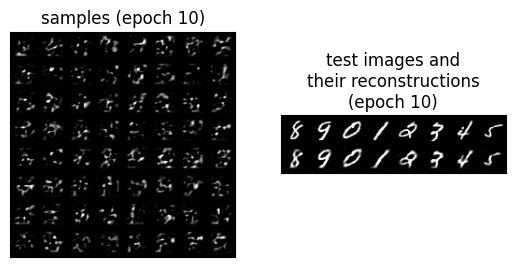

Training epoch 1, batch   0 of 600: BPP = 0.1716; MSE = 0.1160; loss per pixel = 0.1211;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.1928; MSE = 0.0171; loss per pixel = 0.0229;
  prior entropy (per pixel, per latent dim): 0.1317, 1.6133
Training epoch 1, batch  200 of 600: BPP = 0.1992; MSE = 0.0151; loss per pixel = 0.0210;
  prior entropy (per pixel, per latent dim): 0.1350, 1.6534
Training epoch 1, batch  300 of 600: BPP = 0.2053; MSE = 0.0135; loss per pixel = 0.0196;
  prior entropy (per pixel, per latent dim): 0.1380, 1.6903
Training epoch 1, batch  400 of 600: BPP = 0.2055; MSE = 0.0151; loss per pixel = 0.0213;
  prior entropy (per pixel, per latent dim): 0.1400, 1.7144
Training epoch 1, batch  500 of 600: BPP = 0.2074; MSE = 0.0137; loss per pixel = 0.0199;
  prior entropy (per pixel, per latent dim): 0.1409, 1.7258
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.1988, 0.0175, 0.0234;  test: 0.2046, 0.0122, 0.01

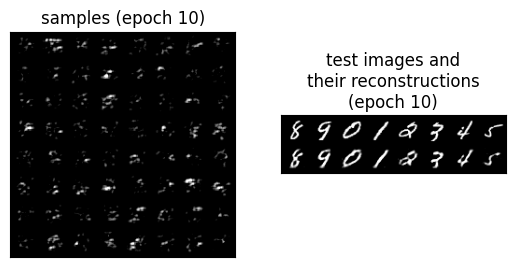

Training epoch 1, batch   0 of 600: BPP = 0.1729; MSE = 0.1117; loss per pixel = 0.1134;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.2300; MSE = 0.0173; loss per pixel = 0.0196;
  prior entropy (per pixel, per latent dim): 0.1389, 1.7009
Training epoch 1, batch  200 of 600: BPP = 0.2537; MSE = 0.0133; loss per pixel = 0.0158;
  prior entropy (per pixel, per latent dim): 0.1669, 2.0440
Training epoch 1, batch  300 of 600: BPP = 0.2648; MSE = 0.0126; loss per pixel = 0.0152;
  prior entropy (per pixel, per latent dim): 0.1806, 2.2125
Training epoch 1, batch  400 of 600: BPP = 0.2732; MSE = 0.0124; loss per pixel = 0.0151;
  prior entropy (per pixel, per latent dim): 0.1867, 2.2872
Training epoch 1, batch  500 of 600: BPP = 0.2789; MSE = 0.0112; loss per pixel = 0.0140;
  prior entropy (per pixel, per latent dim): 0.1913, 2.3433
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.2532, 0.0165, 0.0191;  test: 0.2812, 0.0111, 0.01

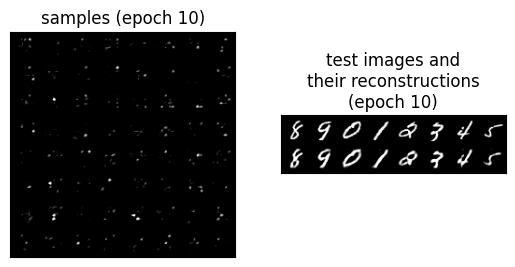

Training epoch 1, batch   0 of 600: BPP = 0.1714; MSE = 0.0912; loss per pixel = 0.0917;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.2684; MSE = 0.0143; loss per pixel = 0.0151;
  prior entropy (per pixel, per latent dim): 0.1588, 1.9453
Training epoch 1, batch  200 of 600: BPP = 0.3030; MSE = 0.0118; loss per pixel = 0.0127;
  prior entropy (per pixel, per latent dim): 0.1944, 2.3815
Training epoch 1, batch  300 of 600: BPP = 0.3143; MSE = 0.0107; loss per pixel = 0.0116;
  prior entropy (per pixel, per latent dim): 0.2124, 2.6013
Training epoch 1, batch  400 of 600: BPP = 0.3220; MSE = 0.0114; loss per pixel = 0.0123;
  prior entropy (per pixel, per latent dim): 0.2216, 2.7152
Training epoch 1, batch  500 of 600: BPP = 0.3278; MSE = 0.0093; loss per pixel = 0.0103;
  prior entropy (per pixel, per latent dim): 0.2267, 2.7772
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): 0.2991, 0.0142, 0.0151;  test: 0.3388, 0.0100, 0.01

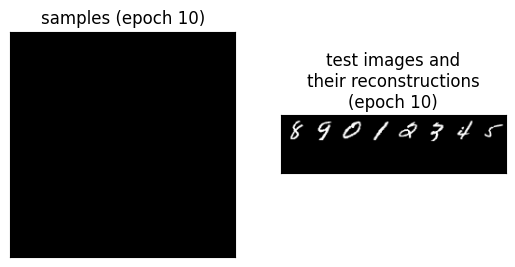

Training epoch 1, batch   0 of 600: BPP = 0.1718; MSE = 0.0947; loss per pixel = 0.0949;
  prior entropy (per pixel, per latent dim): 0.1562, 1.9139
Training epoch 1, batch  100 of 600: BPP = 0.3321; MSE = 0.0154; loss per pixel = 0.0157;
  prior entropy (per pixel, per latent dim): 0.1636, 2.0046
Training epoch 1, batch  200 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Training epoch 1, batch  300 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Training epoch 1, batch  400 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Training epoch 1, batch  500 of 600: BPP = nan; MSE = nan; loss per pixel = nan;
  prior entropy (per pixel, per latent dim): nan, nan
Epoch 1 of 10 (9 sec): training (BPP, MSE, loss): nan, nan, nan;  test: nan, nan, nan
Training epoch 2, batch   0 of 600: BPP = nan; MSE = nan; loss per pixel = 

100%|██████████| 3/3 [40:33<00:00, 811.22s/it]


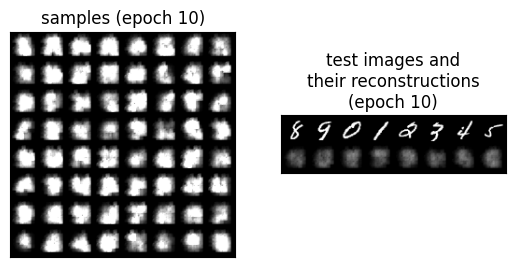

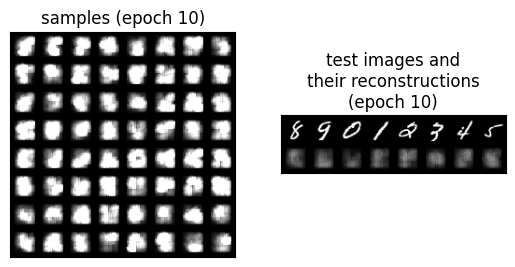

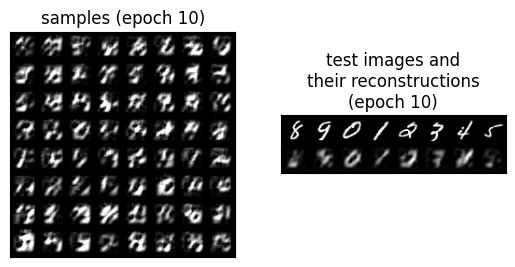

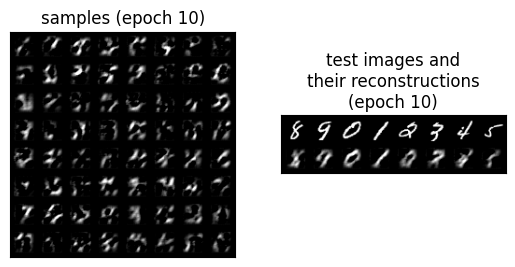

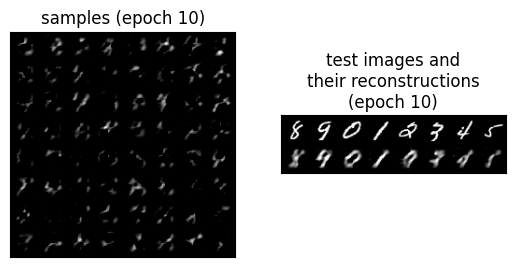

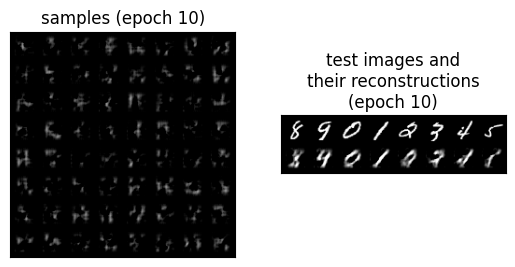

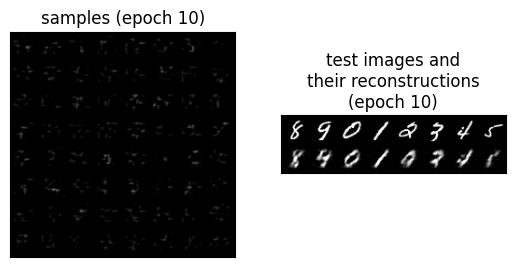

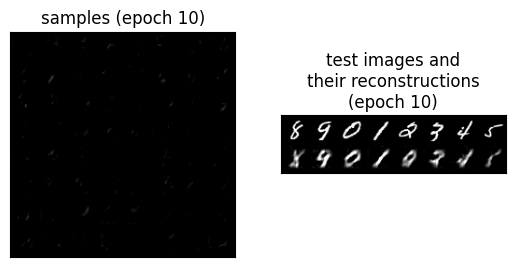

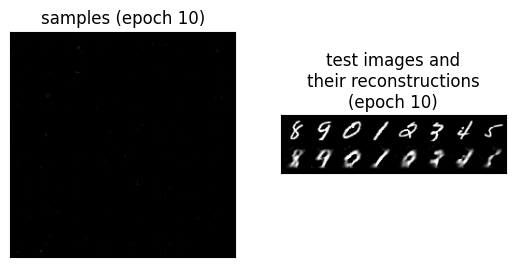

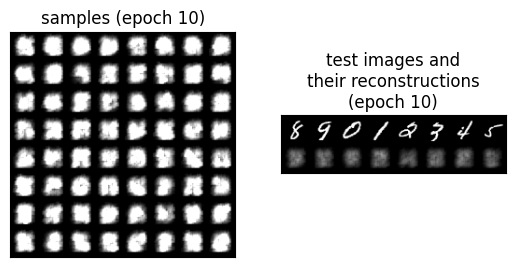

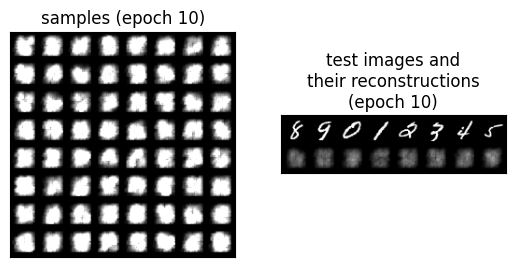

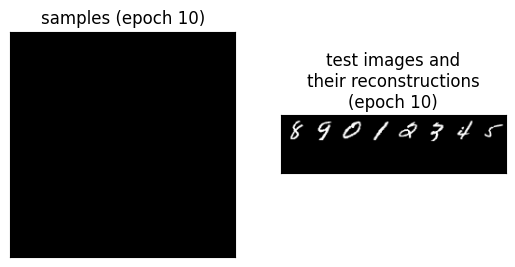

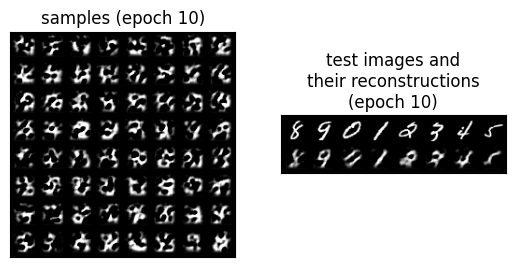

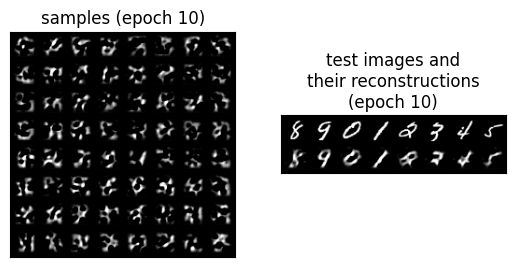

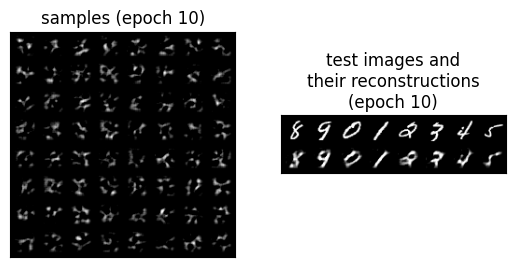

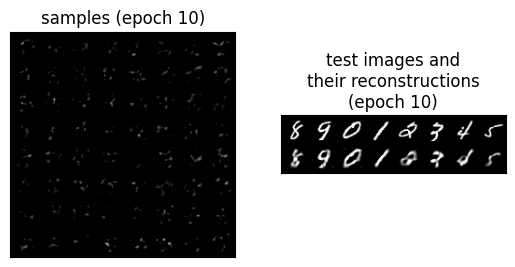

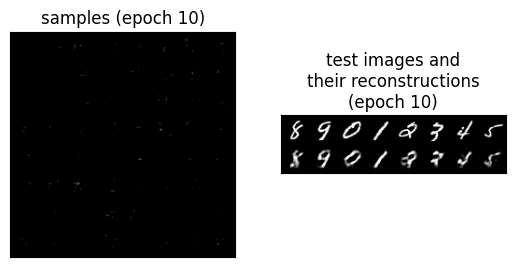

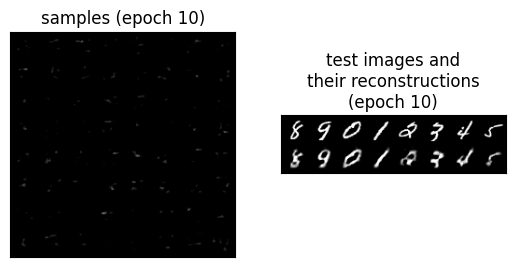

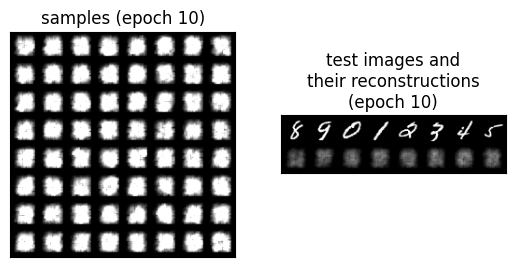

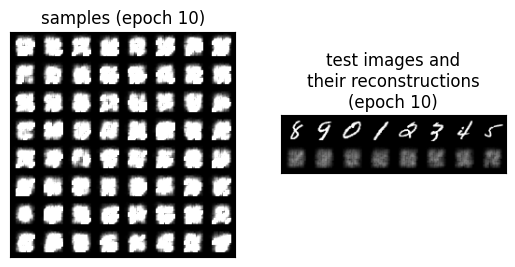

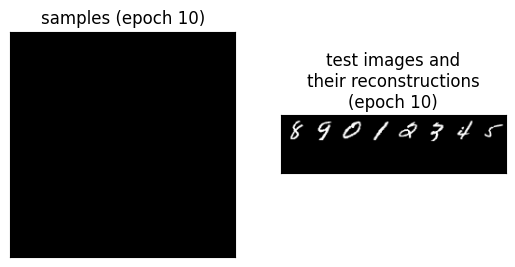

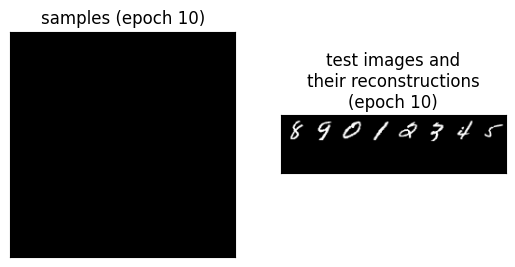

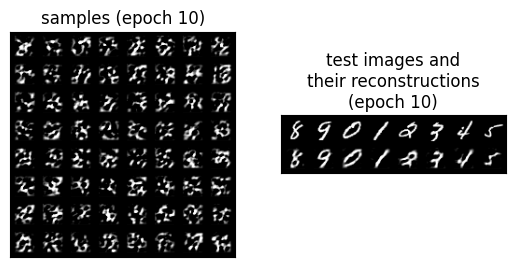

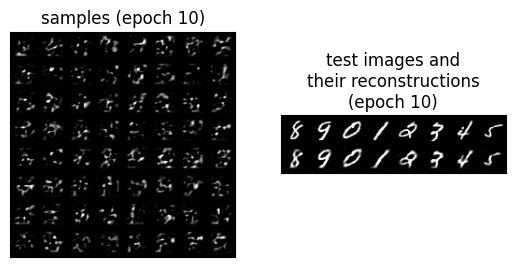

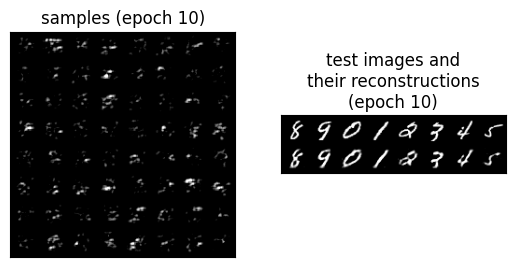

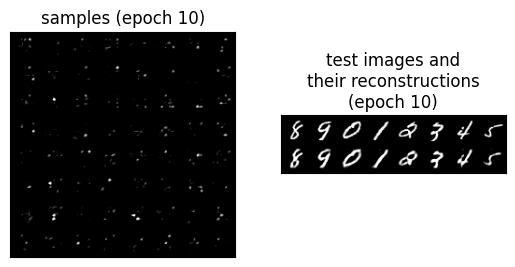

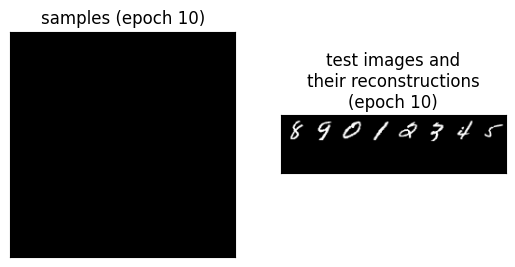

In [14]:
z_channels_options = [1, 2, 4]
betas = [10, 3, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]

test_bpps = np.empty((len(z_channels_options), len(betas)))
test_mses = np.empty((len(z_channels_options), len(betas)))

for i, z_channels in enumerate(tqdm(z_channels_options)):
    for j, beta in enumerate(betas):
        local_encoder_model = EncoderModel(z_channels=z_channels).to(device)
        local_decoder_model = DecoderModel(z_channels=z_channels).to(device)
        local_entropy_bottleneck = EntropyBottleneck(z_channels=z_channels).to(device)

        if USE_CUDA > 1:
            local_encoder_model = nn.DataParallel(local_encoder_model)
            local_decoder_model = nn.DataParallel(local_decoder_model)
            local_entropy_bottleneck = nn.DataParallel(local_entropy_bottleneck)

        local_optimizer = optim.Adam(
            list(local_encoder_model.parameters())
            + list(local_decoder_model.parameters())
            + list(local_entropy_bottleneck.parameters()),
            lr=0.01)

        _, _, local_test_bpp, local_test_mse = training_loop(
            beta, train_loader, local_encoder_model, local_decoder_model,
            local_entropy_bottleneck, local_optimizer)
        test_bpps[i, j] = local_test_bpp
        test_mses[i, j] = local_test_mse

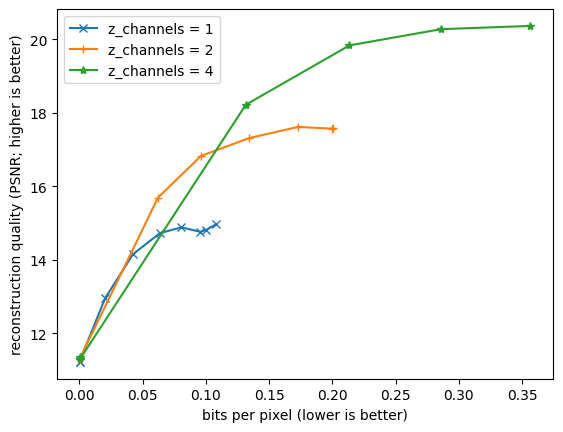

In [15]:
# A popular metric for expressing reconstruction quality is the Peak Signal-to-Noise Ratio (PSNR),
# see https://en.wikipedia.org/wiki/PSNR. Is is defined as PSNR = 10 * log_10(MAX_I^2 / MSE)
# where MSE is the mean squared error and MAX_I^2 is the maxim possible MSE. In our case,
# MAX_I^2 = 1 since pixel values range from 0 to 1, so the maximum squared error is (1-0)^2 = 1.
test_psnrs = -10 * np.log10(test_mses)

fig, ax = plt.subplots()
for i, z_channels in enumerate(z_channels_options):
    ax.plot(test_bpps[i][np.isnan(test_mses[i]) == False], test_psnrs[i][np.isnan(test_mses[i]) == False], 'x+*'[i] + '-', label=f'z_channels = {z_channels}')
ax.set_xlabel('bits per pixel (lower is better)')
ax.set_ylabel('reconstruction quality (PSNR; higher is better)')
ax.legend()

Note that these PSNR values are quite terrible overall, but we're more interested in the general principle than in discussing details of the optimal model architecture.
You should observe the following:
- The quality (PSNR) increases with increasing bit rate, but saturates at some point.
- Models with more $\mathbf z$-channels converge to a better reconstruction quality in the limit of large bit rates.
  This is because, in this limit, the reconstruction quality is only limited by the expressivity of the encoder and decoder neural networks, and models with more latent variables are more expressive.
- For lower bit rates, by contrast, using too many $\mathbf z$-channels hurts reconstruction quality.
  This is likely because the entropy per latent variable becomes extremely low for these models, so the learned prior is very peaked, and the approximation "rounding ≈ adding uniform noise" discussed in Problem 10.1. (c) becomes poor.
- For extremely low (essentially zero) bit rate, all models perform again equaly poorly.
  In this limit, all the model can do is to guess a kind of "average" image that minimizes the average MSE to all training images.

## Lossy Data Compression With the Trained $\beta$-VAE

In this part, you'll use the $\beta$-VAE that you trained above to perform lossy data compression.
The bit rate and distortion of your compression method will depend on the value of $\beta$ that you set when you trained the VAE.

### System Setup

We'll again use the [`constriction`](https://bamler-lab.github.io/constriction/) library that we already used in Problems 7.3 and 9.2 to do the actual entropy coding.

In [16]:
%pip install constriction~=0.3.1


[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import constriction

In [18]:
# Get a batch of test images that we can work with.
test_images, _ = next(test_loader.__iter__())

### Quantizing the Latent Space

At this point, quantization is actually easier than in the lossless case because we always quantize to integers (since the model was trained with a box-shaped variational distribution with fixed width 1).

In [19]:
# NOTE: this cell needs to be rerun every time after training a new model.
prior_std = entropy_bottleneck.prior_std().detach().cpu().numpy()
Z_CUTOFF = 5 * int(round(prior_std.max() + 1.0))
quantized_gaussian = constriction.stream.model.QuantizedGaussian(-Z_CUTOFF, Z_CUTOFF)
print(f'prior standard deviations: {prior_std}')

prior standard deviations: [[[[1.4993302]]

  [[1.0298979]]]]


In [20]:
def quantize_z(z):
    """Map scaled latent representations to the nearest (integer) grid point."""
    return z.round().astype(np.int32)

def unquantize_z(quantized_z):
    """Convert an (integer) grid point to a (float) scaled latent representation."""
    return quantized_z.astype(np.float32)

### Encoder

In [21]:
def encode_single_image(image, range_encoder):
    q_mean = encoder_model(image[None]) # [None] adds a batch dimension
    quantized_z = quantize_z(q_mean.detach().cpu().numpy())
    broadcasted_prior_std = np.broadcast_to(prior_std, quantized_z.shape)
    prior_mean = np.zeros_like(broadcasted_prior_std)
    range_encoder.encode(
        quantized_z.ravel(), quantized_gaussian,
        prior_mean.ravel(), broadcasted_prior_std.ravel())

    return q_mean.shape

### Problem 10.2 (f): Decoder

In [22]:
def decode_single_image(range_decoder, z_shape):
    # TODO: implement the decoder: decode the quantized latent
    # representation, unquantize it, and then use the `decoder_model`
    # to obtain a reconstructed image, which you return.
    # (about 5 to 7 lines of code)
    #
    # PROPOSED SOLUTION:
    broadcasted_prior_std = np.broadcast_to(prior_std, z_shape)
    prior_mean = np.zeros_like(broadcasted_prior_std)
    quantized_z = range_decoder.decode(
        quantized_gaussian, prior_mean.ravel(), broadcasted_prior_std.ravel())
    z = unquantize_z(quantized_z).reshape(z_shape)
    reconstruction = decoder_model(torch.tensor(z))

    return reconstruction[0]

### Testing the Compression Method

In [23]:
def test_compression(images):
    """Encodes and decodes all images, verifies correctness, prints
    the overall number of bits per pixel (BPP), and returns 3 tensors:
    the BPPs for all images, the MSEs for all images, and the
    reconstructed images."""

    encoder = constriction.stream.queue.RangeEncoder()

    bpps = np.empty(len(images))
    for i, image in enumerate(images):
        num_bits_before = encoder.num_bits()
        z_shape = encode_single_image(image, encoder)
        num_bits_after = encoder.num_bits()
        bpps[i] = (num_bits_after - num_bits_before) / image.numel()

    print(f"Encoded {len(images)} images with a BPP of {bpps.mean():.4f} ± {bpps.std():.4f}")
    compressed = encoder.get_compressed()

    # Verify that the method `num_bits` didn't lie:
    assert compressed.dtype == np.uint32
    assert compressed.size * 32 == num_bits_after

    range_decoder = constriction.stream.queue.RangeDecoder(compressed)
    reconstructions = torch.stack([decode_single_image(range_decoder, z_shape) for _ in range(len(images))])
    mses = ((reconstructions - images)**2).mean(axis=(1, 2, 3))
    print(f"Decoded all images, observing a mean squared error of {mses.mean():.4f} ± {mses.std():.4f}")

    return bpps, mses, reconstructions

Encoded 100 images with a BPP of 0.0971 ± 0.0198
Decoded all images, observing a mean squared error of 0.0200 ± 0.0083


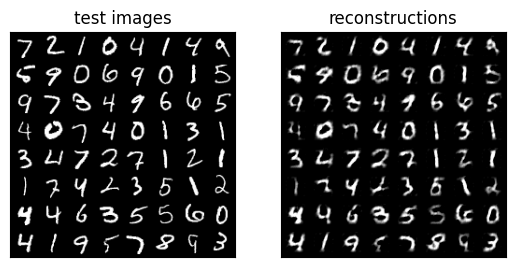

In [24]:
bpps, mses, reconstructions = test_compression(test_images)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

def plot_samples(ax, imgs, title):
    ax.set_title(title)
    ax.imshow(make_grid(imgs[:64]).permute((1, 2, 0)))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

plot_samples(ax1, test_images, "test images")
plot_samples(ax2, reconstructions, "reconstructions")

## Generalization to Out of Distribution Data (OOD)

### Load The OOD Data Set

Make sure that you have the file `smallkkanji2.npz` that was included with last week's problem set, and that it is located at the right path.

In [25]:
import torch.utils.data as data_utils

kanji_data = np.load('kkanji2/smallkkanji2.npz')['data'][:, None, :, :]
kanji_data = torch.tensor(kanji_data.astype(np.float32) / 255)
mock_kanji_labels = torch.zeros((len(kanji_data,))) # We don't need labels but pytorch is very opinionated.

kanji_set = data_utils.TensorDataset(kanji_data, mock_kanji_labels)
kanji_loader = torch.utils.data.DataLoader(kanji_set, batch_size=BATCH_SIZE, shuffle=False)

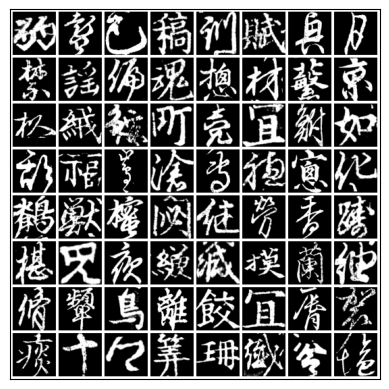

In [26]:
fig, ax = plt.subplots()
ax.imshow(1 - make_grid(1 - kanji_data[:64], padding=4).permute((1, 2, 0)))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

### Try Encoder and Inspect Latent Dimensions

Even though the VAE was trained on images of a different dimension, it should also work on these images (NB: we are a bit lucky here that the padding works out; in general, deconvolutional layers with a $\mathtt{stride}\neq 1$ can reconstruct images whose dimensions differ slightly from the original, which has to be than resolved by output padding).

In [27]:
train_batch, _ = next(train_loader.__iter__())
q_mean = encoder_model(train_batch)
logits = decoder_model(q_mean)
train_batch.shape, q_mean.shape, reconstructions.shape

(torch.Size([100, 1, 28, 28]),
 torch.Size([100, 2, 4, 4]),
 torch.Size([100, 1, 28, 28]))

In [28]:
kanji_batch, _ = next(kanji_loader.__iter__())
q_mean = encoder_model(kanji_batch)
reconstructions = decoder_model(q_mean)
kanji_batch.shape, q_mean.shape, reconstructions.shape

(torch.Size([100, 1, 64, 64]),
 torch.Size([100, 2, 13, 13]),
 torch.Size([100, 1, 64, 64]))

### Test VAE on OOD Data Set

OOD data has BPP = 0.1979; MSE = 0.0309


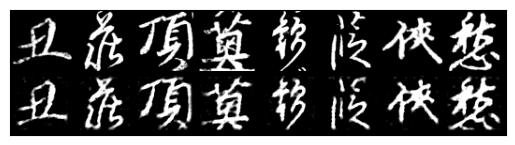

In [29]:
kanji_bpp, kanji_mse, kanji_reconstruction_plot = test(kanji_loader, encoder_model, decoder_model, entropy_bottleneck)
print(f'OOD data has BPP = {kanji_bpp:.4f}; MSE = {kanji_mse:.4f}')
ax = plt.imshow(kanji_reconstruction_plot.detach());
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

### Test Compression Method on OOD Data Set

In [30]:
test_compression(kanji_data);

Encoded 1000 images with a BPP of 0.1986 ± 0.0130
Decoded all images, observing a mean squared error of 0.0308 ± 0.0109
